In [2]:
import re

In [17]:
file_path = 'D:/Code/projects/python/g711/thesis/validate-inference-engines-onnx.txt'

with open(file_path, 'r') as file:
    document_content = file.read()

engine_regex = r"-- Inference Engine: (\w+)"
model_regex = r"-- Model: (/.+?\.(onnx|tflite|pt))"
inference_regex = r"-- Inference: (\d)"
violation_regex = r"Real-time violation: intercepted call to real-time unsafe function `(\w+)` in real-time context!"

data_structure = {}

current_engine, current_model, current_inference = None, None, None

for line in document_content.split('\n'):
    engine_match = re.search(engine_regex, line)
    if engine_match:
        current_engine = engine_match.group(1)
        if current_engine not in data_structure:
            data_structure[current_engine] = {}
        continue

    model_match = re.search(model_regex, line)
    if model_match:
        current_model = model_match.group(1)
        if current_model not in data_structure[current_engine]:
            data_structure[current_engine][current_model] = {}
        continue

    inference_match = re.search(inference_regex, line)
    if inference_match:
        current_inference = inference_match.group(1)
        if current_inference not in data_structure[current_engine][current_model]:
            data_structure[current_engine][current_model][current_inference] = []
        continue

    violation_match = re.search(violation_regex, line)
    if violation_match:
        violation = violation_match.group(1)
        data_structure[current_engine][current_model][current_inference].append(violation)

#print(data_structure)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

In [13]:
def plot_violations_per_model(data_structure, engine):
    models = data_structure[engine].keys()

    for model in models:
        # Find the maximum number of inferences dynamically
        max_inference = max([int(inference) for inference in data_structure[engine][model].keys()])
        num_inferences = max_inference + 1  # Inferences are 0-indexed
        
        all_violations = set()
        for inference in data_structure[engine][model].values():
            for violation in inference:
                all_violations.add(violation)

        sorted_violations = sorted(list(all_violations))

        # Initialize a dict to hold counts for each violation type across inferences
        violation_counts = defaultdict(lambda: [0] * num_inferences)

        # Count occurrences of each violation type per inference
        for inference, violations in data_structure[engine][model].items():
            for violation in violations:
                violation_counts[violation][int(inference)] += 1

        # Plotting
        fig, ax = plt.subplots()
        index = np.arange(num_inferences)
        bar_width = 0.1
        opacity = 0.8

        for i, (violation, counts) in enumerate(violation_counts.items()):
            ax.bar(index + i*bar_width, counts, bar_width, alpha=opacity, label=violation)

        ax.set_xlabel('Inference')
        ax.set_ylabel('Count')
        ax.set_title(f'Violations per Inference for Model {model} in Engine {engine}')
        ax.set_xticks(index + bar_width * len(sorted_violations) / 2 - bar_width / 2)
        ax.set_xticklabels([f'{i}' for i in range(num_inferences)])
        ax.legend()

        plt.tight_layout()
        plt.show()  


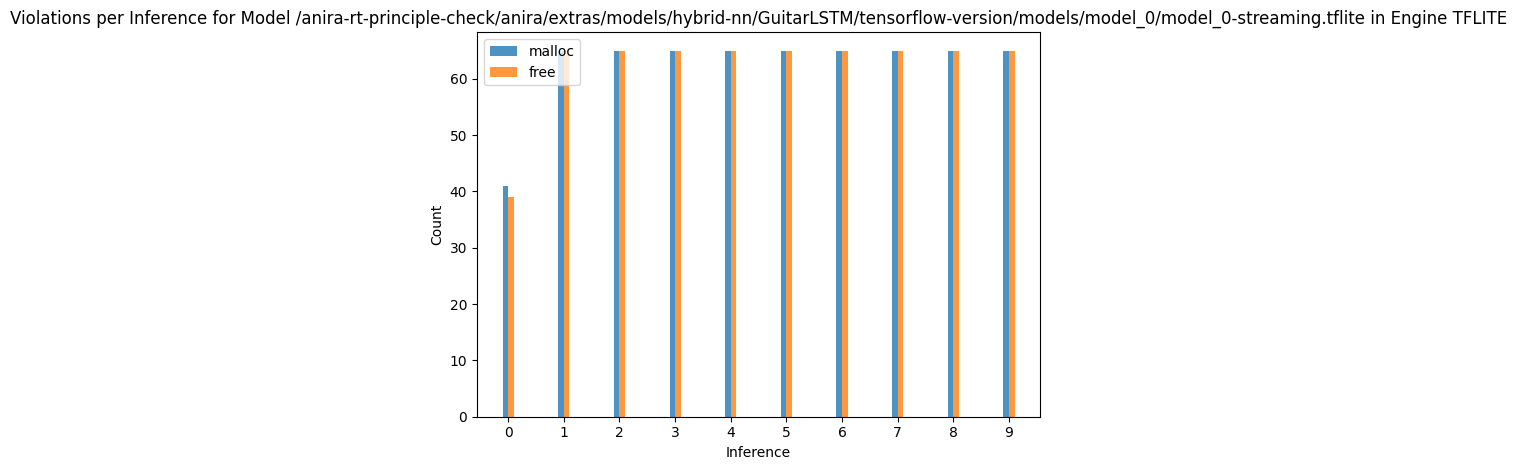

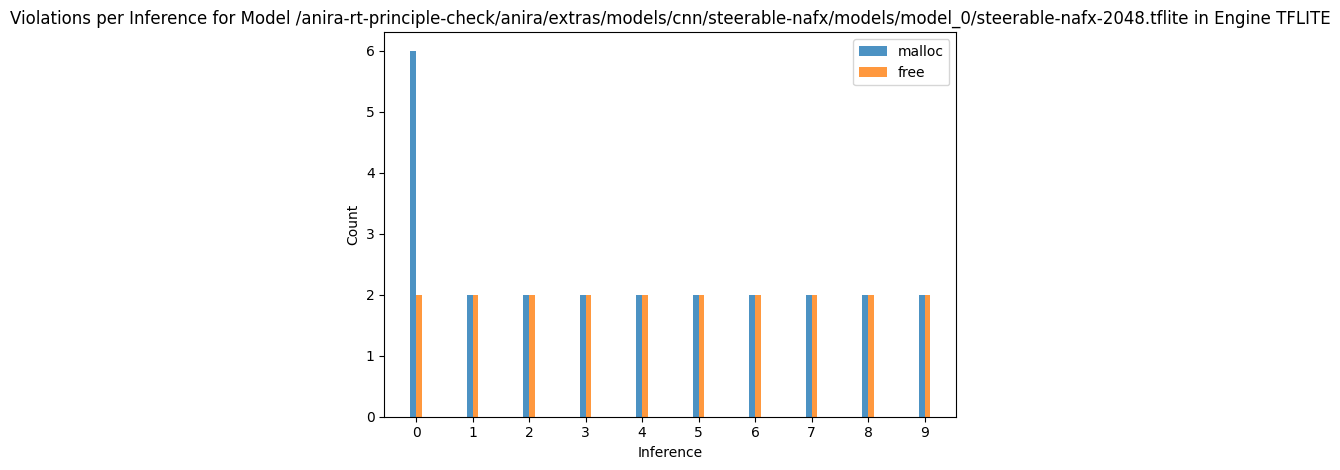

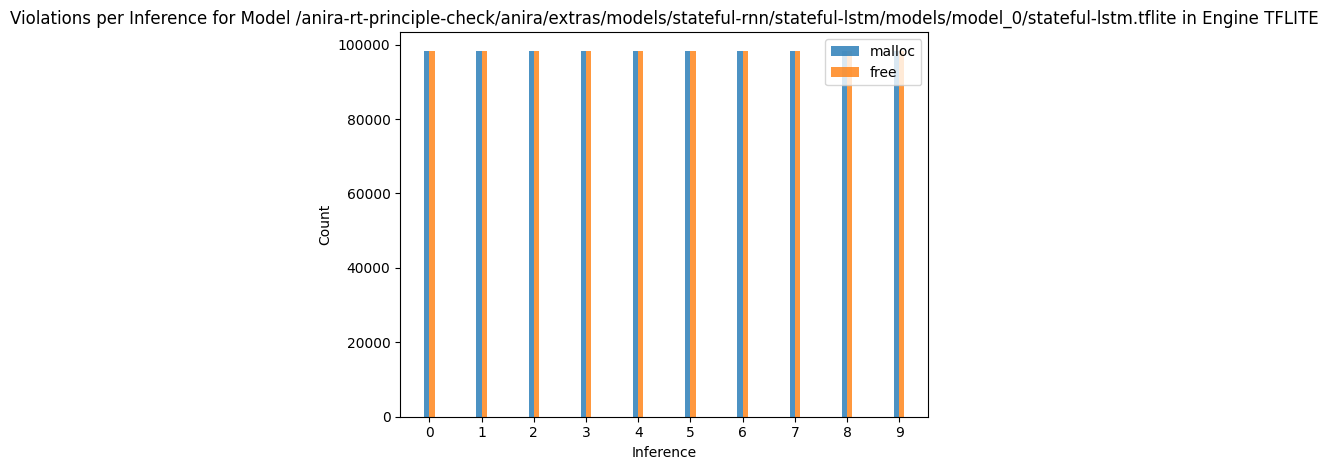

In [14]:
plot_violations_per_model(data_structure, 'TFLITE')

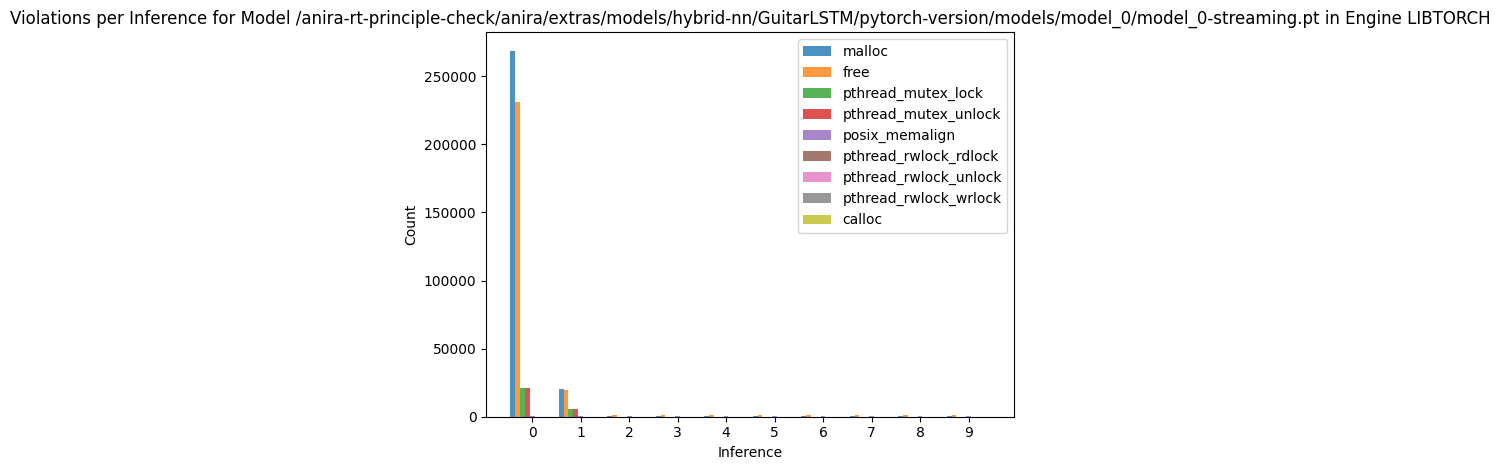

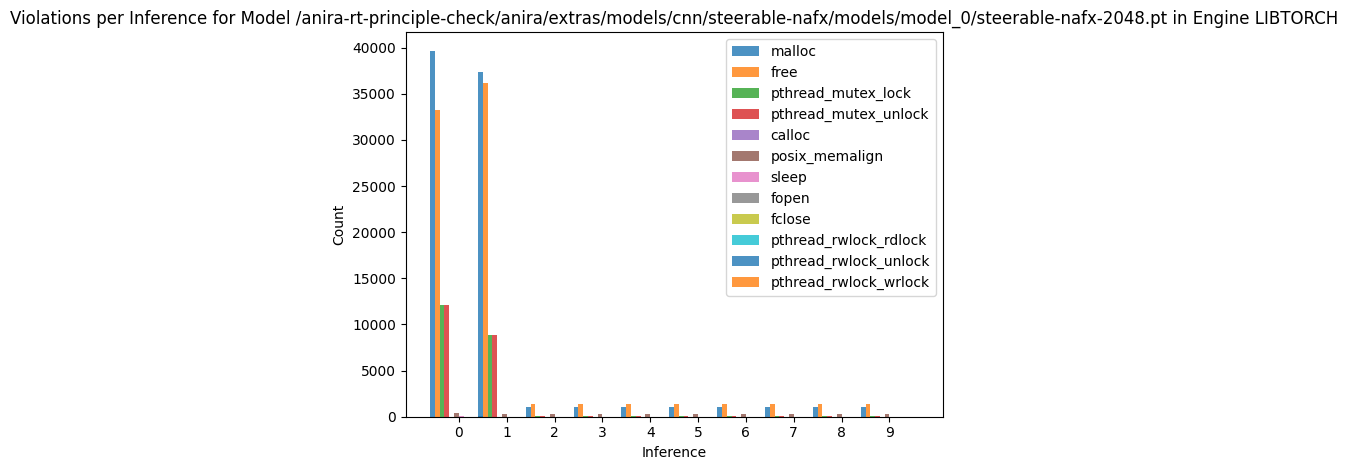

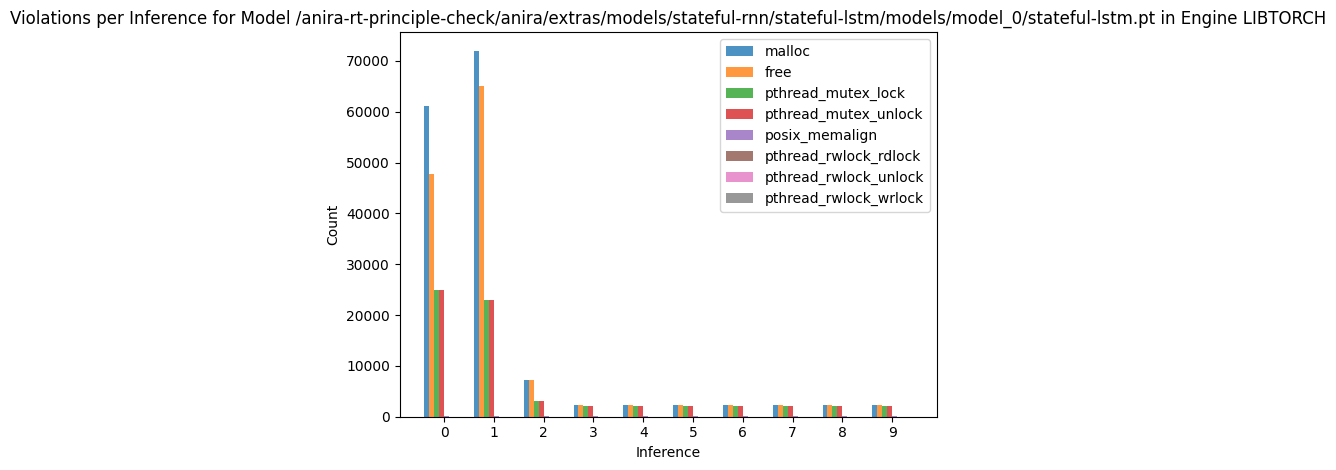

In [16]:
plot_violations_per_model(data_structure, 'LIBTORCH')

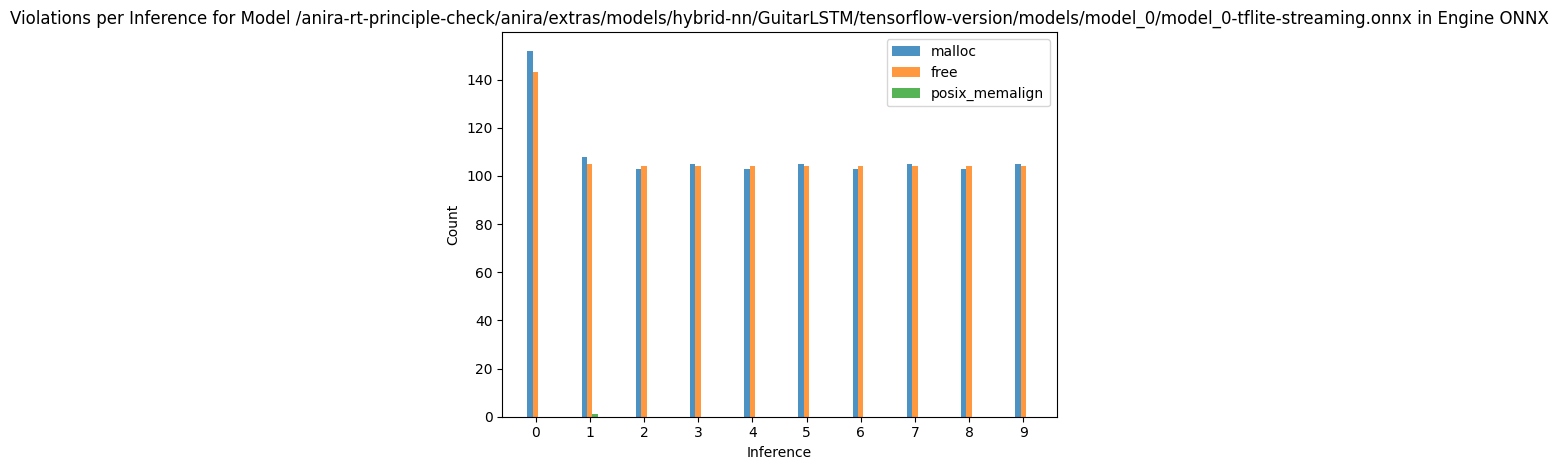

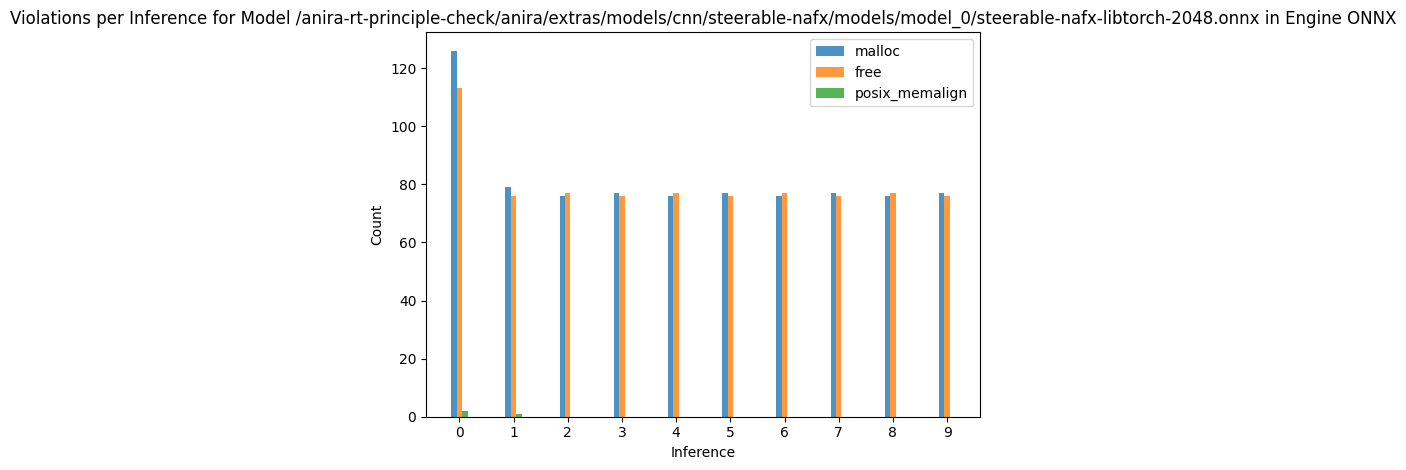

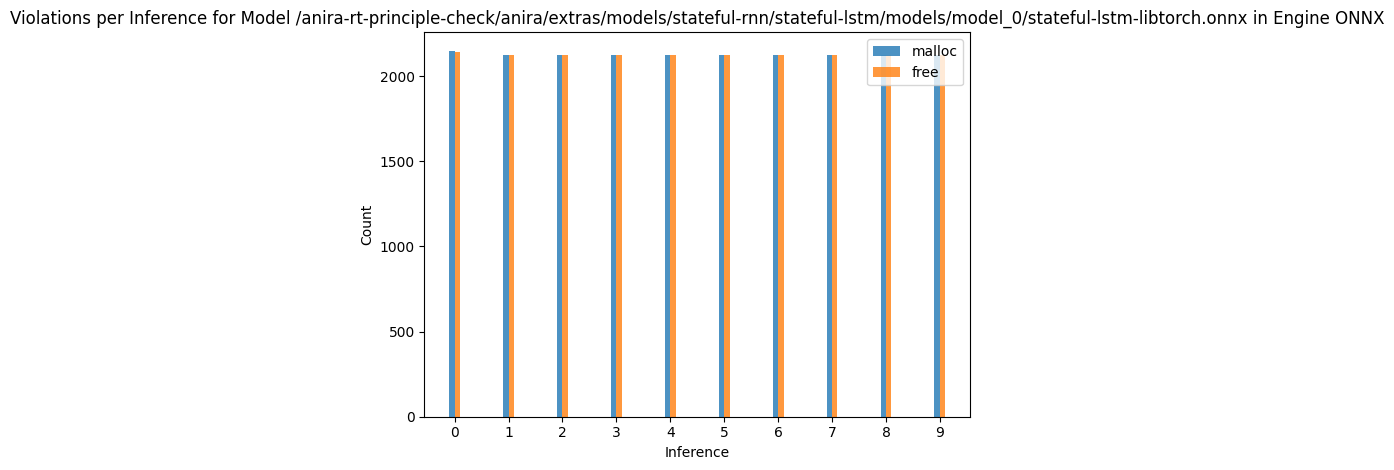

In [18]:
plot_violations_per_model(data_structure, 'ONNX')